# Statistik-Projekt HS25 – Notebook 04: Bahnhofsanalyse
## Ziel
Nach der globalen Betrachtung fokussieren wir uns in diesem Notebook auf einen spezifischen Knotenpunkt: **Zürich HB** (oder einen anderen Bahnhof nach Wahl).
Wir untersuchen, ob die globalen Muster (Rush-Hour-Problematik, S-Bahn vs. Fernverkehr) auch lokal an diesem Bahnhof gelten oder ob es abweichende Dynamiken gibt.

## Fragestellungen
1.  Wie pünktlich ist dieser Bahnhof im Vergleich zum nationalen Durchschnitt?
2.  Zu welcher Uhrzeit ist die Lage am kritischsten (Heatmap)?
3.  Welche Linien sind die "Sorgenkinder" an diesem Bahnhof?

## Input
* Datei: `../data/processed/istdata_clean_extended.parquet`

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Konfiguration
INPUT_PATH = "../../data/processed/istdata_clean_extended.parquet"
TARGET_STATION = "Zürich HB"  # <-- HIER Bahnhof ändern (z.B. "Bern", "Basel SBB")

# 2. Daten laden (Lazy)
print(f"Lade Daten für Bahnhofsanalyse...")
lf = pl.scan_parquet(INPUT_PATH)

# 3. Filter auf den Zielbahnhof
# Wir filtern schon im Lazy-Modus, das spart extrem viel Speicher!
lf_station = lf.filter(pl.col("HALTESTELLEN_NAME") == TARGET_STATION)

# Daten materialisieren (in RAM laden)
df_station = lf_station.collect().to_pandas()

print(f"Daten für '{TARGET_STATION}' geladen: {len(df_station):,} Ankünfte.")

if len(df_station) == 0:
    print("ACHTUNG: Keine Daten gefunden! Bitte prüfen Sie die Schreibweise des Bahnhofs.")
    # Kurzer Check, welche Bahnhöfe es gibt (falls Tippfehler)
    all_stations = lf.select("HALTESTELLEN_NAME").unique().head(20).collect()
    print("Beispiele für Bahnhöfe:", all_stations["HALTESTELLEN_NAME"].to_list())

Lade Daten für Bahnhofsanalyse...
Daten für 'Zürich HB' geladen: 51,695 Ankünfte.


In [2]:
# Wir laden kurz die globalen Stats (nur Mean/Median), um zu vergleichen
# Achtung: Das machen wir effizient ohne alles zu laden
global_stats = lf.select([
    pl.col("arr_delay_min").mean().alias("Global_Mean"),
    pl.col("arr_delay_min").median().alias("Global_Median")
]).collect()

local_mean = df_station["arr_delay_min"].mean()
local_median = df_station["arr_delay_min"].median()
local_on_time = (df_station["arr_delay_min"] < 3).mean() * 100

print(f"--- Vergleich für {TARGET_STATION} ---")
print(f"Mittlere Verspätung: {local_mean:.2f} min (Schweiz: {global_stats['Global_Mean'][0]:.2f} min)")
print(f"Median Verspätung:   {local_median:.2f} min (Schweiz: {global_stats['Global_Median'][0]:.2f} min)")
print(f"Pünktlichkeit (<3'): {local_on_time:.1f}%")

--- Vergleich für Zürich HB ---
Mittlere Verspätung: 1.16 min (Schweiz: 0.93 min)
Median Verspätung:   0.57 min (Schweiz: 0.62 min)
Pünktlichkeit (<3'): 92.9%


/tmp/ipykernel_27125/2510795468.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


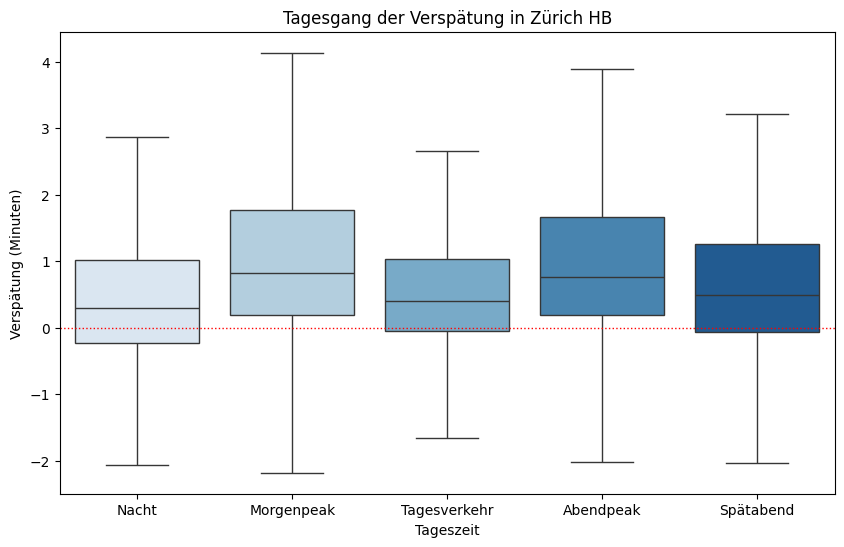

In [3]:
time_order = ["Nacht", "Morgenpeak", "Tagesverkehr", "Abendpeak", "Spätabend"]

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_station,
    x="time_band",
    y="arr_delay_min",
    order=time_order,
    showfliers=False, # Outlier ausblenden für Übersicht
    palette="Blues"
)

plt.title(f"Tagesgang der Verspätung in {TARGET_STATION}")
plt.ylabel("Verspätung (Minuten)")
plt.xlabel("Tageszeit")
plt.axhline(0, color='red', linestyle=':', linewidth=1)
plt.show()

--- Top 10 unpünktlichste Linien in Zürich HB ---


,LINIEN_TEXT,median,count,mean
1,EC,2.408333,676,10.903723
38,S20,2.166667,153,2.329956
21,NJ,2.083333,119,16.900700
28,RJX,1.983333,171,13.355458
40,S23,1.800000,105,2.038254
59,TGV,1.566667,119,6.921849
42,S25,1.516667,450,1.780185
3,IC,1.483333,657,4.740589
18,IR46,1.400000,268,1.417724
11,ICE,1.333333,203,4.908046


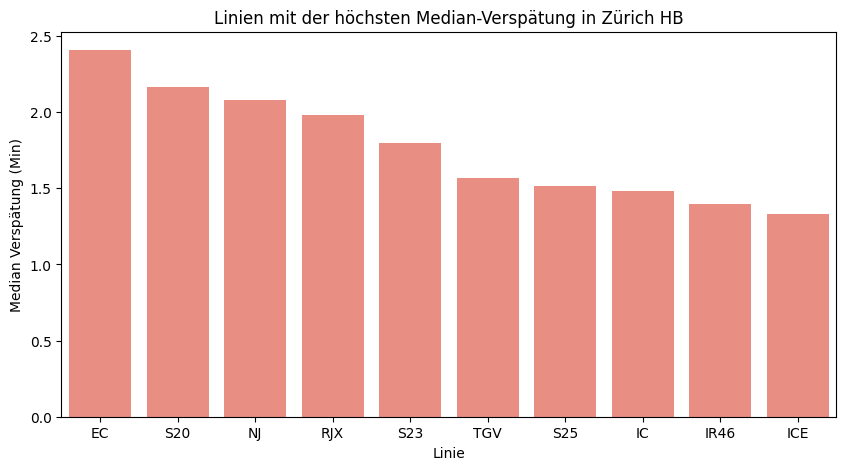

In [4]:
# Wir gruppieren nach Linie und berechnen Median & Anzahl
line_stats = (
    df_station.groupby("LINIEN_TEXT")["arr_delay_min"]
    .agg(["median", "count", "mean"])
    .reset_index()
)

# Nur Linien mit mind. 50 Fahrten (um Ausreisser durch Einzelereignisse zu vermeiden)
line_stats = line_stats[line_stats["count"] > 50]

# Top 10 der unpünktlichsten Linien (nach Median sortiert)
top_delay_lines = line_stats.sort_values("median", ascending=False).head(10)

print(f"--- Top 10 unpünktlichste Linien in {TARGET_STATION} ---")
display(top_delay_lines)

# Visualisierung
plt.figure(figsize=(10, 5))
sns.barplot(data=top_delay_lines, x="LINIEN_TEXT", y="median", color="salmon")
plt.title(f"Linien mit der höchsten Median-Verspätung in {TARGET_STATION}")
plt.ylabel("Median Verspätung (Min)")
plt.xlabel("Linie")
plt.show()

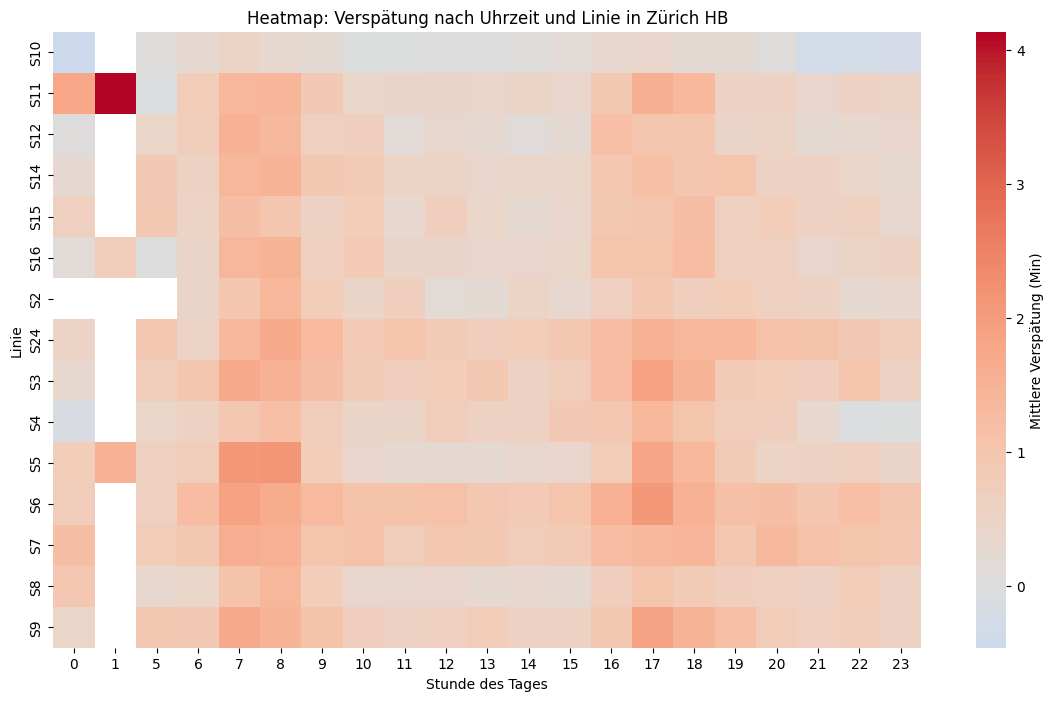

Interpretation: Rote Bereiche zeigen systematische Verspätungen (z.B. immer 17:00 Uhr auf Linie XY). Blaue Bereiche zeigen Puffer/Verfrühung.


In [5]:
# Wir nehmen die Top 15 Linien (nach Anzahl Fahrten), damit die Grafik lesbar bleibt
top_freq_lines = df_station["LINIEN_TEXT"].value_counts().head(15).index
df_heatmap = df_station[df_station["LINIEN_TEXT"].isin(top_freq_lines)].copy()

# Pivot Tabelle: Zeilen=Linien, Spalten=Stunde, Werte=Mittlere Verspätung
heatmap_data = df_heatmap.pivot_table(
    index="LINIEN_TEXT",
    columns="hour_of_day",
    values="arr_delay_min",
    aggfunc="mean" # oder "median"
)

# Plot
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data, 
    cmap="coolwarm", 
    center=0, 
    annot=False, # True wenn ihr Zahlen wollt (kann unübersichtlich sein)
    cbar_kws={'label': 'Mittlere Verspätung (Min)'}
)
plt.title(f"Heatmap: Verspätung nach Uhrzeit und Linie in {TARGET_STATION}")
plt.xlabel("Stunde des Tages")
plt.ylabel("Linie")
plt.show()

print("Interpretation: Rote Bereiche zeigen systematische Verspätungen (z.B. immer 17:00 Uhr auf Linie XY). Blaue Bereiche zeigen Puffer/Verfrühung.")

In [7]:
import polars as pl
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm

# 1. Daten laden (Aggregieren pro Bahnhof)
# Wir nehmen die Clean-Daten und gruppieren nach BPUIC (Bahnhofs-ID)
df = pl.read_parquet("../../data/processed/istdata_clean_extended.parquet")

print("Aggregiere Verspätungen pro Bahnhof...")
station_stats = (
    df.group_by("BPUIC")
    .agg([
        pl.col("HALTESTELLEN_NAME").first().alias("Name"),
        pl.col("arr_delay_min").mean().alias("Mean_Delay"),
        pl.col("arr_delay_min").median().alias("Median_Delay"),
        pl.len().alias("Anzahl_Fahrten")
    ])
    .filter(pl.col("Anzahl_Fahrten") > 100) # Nur relevante Bahnhöfe
    .to_pandas()
)

# 2. Geodaten laden (aus dienststellen.csv)
# Die Datei liegt in data/external/dienststellen.csv
geo_df = pd.read_csv("../../data/external/dienststellen.csv", sep=";")

# Wir brauchen 'number' (entspricht BPUIC) und 'Geoposition'
# Geoposition ist im Format "47.378, 8.540" -> Splitten
geo_df = geo_df[["number", "Geoposition"]].dropna()
geo_df["number"] = geo_df["number"].astype(str) # BPUIC ist oft String
# Split Coordinates
latlon = geo_df["Geoposition"].str.split(",", expand=True)
geo_df["lat"] = pd.to_numeric(latlon[0])
geo_df["lon"] = pd.to_numeric(latlon[1])

# 3. Joinen
station_map_data = station_stats.merge(
    geo_df, 
    left_on="BPUIC", 
    right_on="number", 
    how="inner"
)

print(f"{len(station_map_data)} Bahnhöfe mit Koordinaten gefunden.")

# 4. Karte erstellen
# Startpunkt: Schweiz Zentrum
m = folium.Map(location=[46.8182, 8.2275], zoom_start=8, tiles="cartodbpositron")

# Farbskala für Verspätung (Grün bis Rot)
colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=0, vmax=3)
colormap.caption = 'Mittlere Verspätung (Minuten)'
colormap.add_to(m)

# Cluster für Performance (damit der Browser nicht abstürzt bei tausenden Punkten)
marker_cluster = MarkerCluster().add_to(m)

for idx, row in station_map_data.iterrows():
    # Farbe bestimmen
    delay = row['Mean_Delay']
    color = colormap(delay) if delay < 5 else 'black' # Schwarz für extremes Chaos
    
    # Radius basierend auf Anzahl Fahrten (grösser = wichtiger)
    radius = 3 + (row['Anzahl_Fahrten'] / station_map_data['Anzahl_Fahrten'].max()) * 10

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"<b>{row['Name']}</b><br>Ø Verspätung: {delay:.2f} min<br>Fahrten: {row['Anzahl_Fahrten']}", max_width=300)
    ).add_to(marker_cluster)

# Karte speichern und anzeigen
m.save("../reports/figures/suisse_delay_map.html")
m # Zeigt die Karte direkt im Notebook an

Aggregiere Verspätungen pro Bahnhof...
1599 Bahnhöfe mit Koordinaten gefunden.
